In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from src.utils.general import get_db_conn, get_boto3_session, load_model_s3, load_matrix_s3
from src.utils import project_constants as constants

from src.bill_passage.model_analysis_functions import fetch_evaluations_models, fetch_all_evaluations_for_model

In [3]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file)
s3_session = get_boto3_session(cred_file)

#### Single Model

In [47]:
model_id = 11783
q = """select * from test_results.crosstabs_bins where model_id={}""".format(model_id)

crosstabs = pd.read_sql(q, db_conn)
crosstabs.head()

,model_id,as_of_date,metric,related_likelihood_bins,feature_name,value
0,11783,2018-01-08,mean,coin-toss,txt_entity_id_all_text_size_max,20642.323031
1,11783,2018-01-08,mean,coin-toss,txt_entity_id_all_text_size_min,19039.208392
2,11783,2018-01-08,count,will_pass,txt_entity_id_all_text_size_min,8.000000
3,11783,2018-01-15,std,likely,txt_entity_id_1week_doc_id_count,0.577930
4,11783,2018-01-08,count,will_not_pass,sponsors_entity_id_all_dems_frac_max,704.000000


In [48]:
bins_interested_in = ['will_pass', 'will_not_pass']
metric_msk = crosstabs['metric'] == 'mean_ratio'
bins_msk = crosstabs['related_likelihood_bins'] == ', '.join(bins_interested_in)

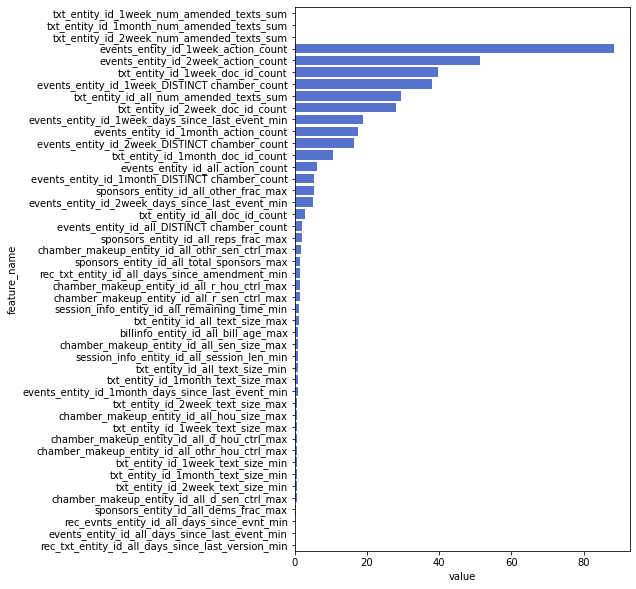

In [50]:
t = crosstabs[metric_msk & bins_msk].groupby('feature_name', as_index=False).mean().sort_values('value', ascending=False)

fig, ax = plt.subplots(figsize=(6, 10))
sns.barplot(
    data=t,
    x='value',
    y='feature_name',
    ax=ax,
    color='royalblue'
)

**Inspect feature & metric**

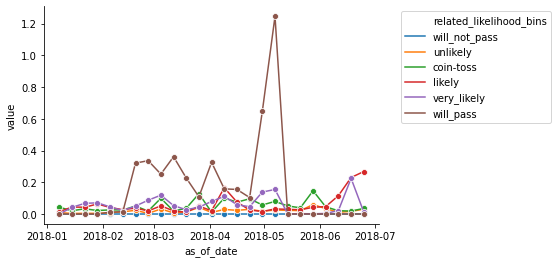

In [51]:
feature_name = 'txt_entity_id_1week_num_amended_texts_sum'
metric='mean'

msk = (crosstabs['feature_name'] == feature_name) & (crosstabs['metric'] == metric)

sns.lineplot(
    data=crosstabs[msk],
    x='as_of_date',
    y='value',
    hue='related_likelihood_bins',
    marker='o'
)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1))

In [21]:
print(list(crosstabs['feature_name'].unique()))

['sponsors_entity_id_all_dems_frac_max', 'sponsors_entity_id_all_other_frac_max', 'sponsors_entity_id_all_reps_frac_max', 'sponsors_entity_id_all_total_sponsors_max', 'events_entity_id_1month_DISTINCT chamber_count', 'events_entity_id_1month_action_count', 'events_entity_id_1month_days_since_last_event_min', 'events_entity_id_1week_DISTINCT chamber_count', 'events_entity_id_1week_action_count', 'events_entity_id_1week_days_since_last_event_min', 'events_entity_id_2week_DISTINCT chamber_count', 'events_entity_id_2week_action_count', 'events_entity_id_2week_days_since_last_event_min', 'events_entity_id_all_DISTINCT chamber_count', 'events_entity_id_all_action_count', 'events_entity_id_all_days_since_last_event_min', 'billinfo_entity_id_all_bill_age_max', 'chamber_makeup_entity_id_all_d_hou_ctrl_max', 'chamber_makeup_entity_id_all_d_sen_ctrl_max', 'chamber_makeup_entity_id_all_hou_size_max', 'chamber_makeup_entity_id_all_othr_hou_ctrl_max', 'chamber_makeup_entity_id_all_othr_sen_ctrl_max'

In [29]:
feature_name = 'txt_entity_id_1week_doc_id_count'
msk = (crosstabs['feature_name'] == feature_name) & (crosstabs['metric'] == 'mean')
crosstabs[msk]

,model_id,as_of_date,metric,related_likelihood_bins,feature_name,value
76,11784,2018-07-01,mean,will_not_pass,txt_entity_id_1week_doc_id_count,0.060512
214,11784,2018-07-01,mean,unlikely,txt_entity_id_1week_doc_id_count,0.070012
352,11784,2018-07-01,mean,coin-toss,txt_entity_id_1week_doc_id_count,0.066406
491,11784,2018-07-01,mean,likely,txt_entity_id_1week_doc_id_count,0.098459
628,11784,2018-07-01,mean,very_likely,txt_entity_id_1week_doc_id_count,0.246154
...,...,...,...,...,...,...
78050,11784,2018-12-30,mean,unlikely,txt_entity_id_1week_doc_id_count,0.042254
78185,11784,2018-12-30,mean,coin-toss,txt_entity_id_1week_doc_id_count,0.184211
78322,11784,2018-12-30,mean,likely,txt_entity_id_1week_doc_id_count,1.000000
78460,11784,2018-12-30,mean,very_likely,txt_entity_id_1week_doc_id_count,0.000000
